# MNIST QNN - Blind Quantum Computing

Este notebook demonstra como treinar um modelo de Rede Neural Quântica (QNN)
usando o Qiskit Machine Learning e circuitos gerados a partir de arquivos QASM
da base MNIST.

In [4]:
!pip install qiskit qiskit-aer qiskit-machine-learning numpy matplotlib torch scikit-learn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import random
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from quantumnet.components import Network, Logger

from qiskit_aer.noise import NoiseModel, depolarizing_error
%matplotlib inline


# Controle de Aleatoriedade e Reprodutibilidade

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Callback: envio do circuito por época
E outras funções para visualização.

In [ ]:
def enviar_circuito_por_epoca(circuito, epoch, num_qubits, circuit_depth):
    print(f"[Epoch {epoch+1}] Enviando circuito para a rede...")
    try:
        rede.application_layer.run_app(
            "BFK_BQC",
            alice_id=6,
            bob_id=0,
            num_qubits=num_qubits,
            scenario=2,
            circuit_depth=circuit_depth,
            circuit=circuito
        )
        print(f"[Epoch {epoch+1}] Envio concluído.")
    except Exception as e:
        print(f"[Epoch {epoch+1}] Erro ao enviar circuito: {str(e)}")

def show_figure(pict, index=0):
    try:
        pict = np.asarray(pict, dtype=np.float64).ravel()
        if pict.max() > 0:
            pict = pict / pict.max()
        size = len(pict)
        dim = int(np.ceil(np.sqrt(size)))
        padded = np.zeros((dim * dim,))
        padded[:size] = pict
        plt.imshow(padded.reshape(dim, dim), cmap="Greys")
        plt.axis('off')
        plt.savefig(f"figura_{index}.png", bbox_inches='tight', pad_inches=0)
        plt.close()
        #plt.show()
    except Exception as e:
        print(f"Erro ao salvar figura {index}: {str(e)}")

def show_state_figure(statevector, index=0):
    try:
        if hasattr(statevector, 'data'):
            statevector = statevector.data
        statevector = np.asarray(statevector, dtype=np.complex128)
        probs = np.abs(statevector) ** 2
        if len(probs) < 784:
            padded = np.zeros(784)
            padded[:len(probs)] = probs
            probs = padded
        show_figure(probs, index=index)
    except Exception as e:
        print(f"Erro ao processar estado {index}: {str(e)}")



# Inicializar a rede

In [8]:
rede = Network()
rede.set_ready_topology('grade', 8, 3, 3)
Logger.activate(Logger)


Hosts inicializados
Canais inicializados
Pares EPRs adicionados


# Inicializar o Backend com Ruído

In [9]:

noise_model = NoiseModel()

error_1q = depolarizing_error(0.01, 1)
error_2q = depolarizing_error(0.02, 2)

noise_model.add_all_qubit_quantum_error(error_1q, ['h','x','y','rx','ry','rz'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

simulator = AerSimulator(noise_model=noise_model, shots=1024)


# Carregar os arquivos QASM da base MNIST.

In [10]:
path = "base_test_mnist_784_f90/qasm/"

file_list = sorted(os.listdir(path))[:20]
states = []
labels = []

for i, file_name in enumerate(file_list):
    try:
        full_path = os.path.join(path, file_name)
        with open(full_path) as f:
            qasm = f.read()
            qc = QuantumCircuit.from_qasm_str(qasm)
            qc.save_statevector()
            compiled = transpile(qc, simulator)
            job = simulator.run(compiled)
            result = job.result()
            state = result.data(0)['statevector']
            show_state_figure(state, index=i)
            features = np.abs(state)**2
            features = features[:4]
            states.append(features)
            labels.append(0 if i < 10 else 1)
    except Exception as e:
        print(f"Erro ao processar {file_name}: {str(e)}")


# Divide os dados

In [11]:

X = torch.tensor(states, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
X_train_tensor = X
y_train_tensor = y

num_qubits =  X.shape[1]
print(f"Num qubits (features) = {num_qubits}")

Num qubits (features) = 4


/tmp/ipykernel_15195/875786924.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(states, dtype=torch.float32)


# Cria o circuito quântico (FeatureMap + Ansatz)

In [12]:

feature_map = ZZFeatureMap(num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

qc_base = QuantumCircuit(num_qubits)
qc_base.compose(feature_map, inplace=True)
qc_base.compose(ansatz, inplace=True)


print('Circuito pronto. Depth aproximado:', qc.depth())

Circuito pronto. Depth aproximado: 163


# EstiamdorQNN

In [13]:
observable = SparsePauliOp("Z" * num_qubits)
estimator = Estimator()

qnn = EstimatorQNN(
    circuit=qc_base,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    observables=observable,
    estimator=estimator,
    input_gradients=True
)

model = TorchConnector(qnn)
loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


print('QNN (QuantumNeuralNetwork) configurado.')

/tmp/ipykernel_15195/2000550838.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/tmp/ipykernel_15195/2000550838.py:4: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


QNN (QuantumNeuralNetwork) configurado.


# Treinamento

In [14]:
print("\nINICIANDO TREINAMENTO VQC...")
for epoch in range(10):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_func(torch.sigmoid(output.squeeze()), y_train_tensor.squeeze())
    loss.backward()
    optimizer.step()

    trained_weights = model.weight.detach().numpy()
    final_circuit = QuantumCircuit(num_qubits)
    final_circuit.compose(feature_map, inplace=True)
    final_circuit.compose(ansatz.assign_parameters(trained_weights), inplace=True)

    enviar_circuito_por_epoca(
        circuito=final_circuit,
        epoch=epoch,
        num_qubits=final_circuit.num_qubits,
        circuit_depth=final_circuit.depth()
    )
    rede.start_eprs(5)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")


INICIANDO TREINAMENTO VQC...


2025-08-24 03:44:42,742: Protocolo configurado para 2 rodadas.
2025-08-24 03:44:42,743: Timeslot 1. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:44:42,744: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:44:42,744: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:44:42,745: Timeslot 2.
2025-08-24 03:44:42,745: Qubit 104 preparado pelo cliente 6.
2025-08-24 03:44:42,746: Qubit 367 preparado pelo cliente 6.
2025-08-24 03:44:42,746: Qubit 826 preparado pelo cliente 6.
2025-08-24 03:44:42,747: Qubit 549 preparado pelo cliente 6.
2025-08-24 03:44:42,748: Calculando rota padrão para o transporte.
2025-08-24 03:44:42,748: Timeslot 3: Buscando rota válida entre 6 e 0.
2025-08-24 03:44:42,749: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:44:42,750: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:44:42,751: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:44:42,751: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 03:4

[Epoch 1] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 1] Envio concluído.
Pares EPRs adicionados


2025-08-24 03:44:46,570: Protocolo configurado para 2 rodadas.
2025-08-24 03:44:46,571: Timeslot 17. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:44:46,572: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:44:46,572: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:44:46,573: Timeslot 18.
2025-08-24 03:44:46,573: Qubit 623 preparado pelo cliente 6.
2025-08-24 03:44:46,574: Qubit 167 preparado pelo cliente 6.
2025-08-24 03:44:46,574: Qubit 947 preparado pelo cliente 6.
2025-08-24 03:44:46,575: Qubit 701 preparado pelo cliente 6.
2025-08-24 03:44:46,576: Calculando rota padrão para o transporte.
2025-08-24 03:44:46,576: Timeslot 19: Buscando rota válida entre 6 e 0.
2025-08-24 03:44:46,577: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:44:46,578: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:44:46,578: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:44:46,579: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 0

[Epoch 2] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 2] Envio concluído.
Pares EPRs adicionados


2025-08-24 03:44:50,810: Protocolo configurado para 2 rodadas.
2025-08-24 03:44:50,811: Timeslot 33. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:44:50,811: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:44:50,813: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:44:50,814: Timeslot 34.
2025-08-24 03:44:50,814: Qubit 224 preparado pelo cliente 6.
2025-08-24 03:44:50,815: Qubit 521 preparado pelo cliente 6.
2025-08-24 03:44:50,816: Qubit 881 preparado pelo cliente 6.
2025-08-24 03:44:50,817: Qubit 811 preparado pelo cliente 6.
2025-08-24 03:44:50,818: Calculando rota padrão para o transporte.
2025-08-24 03:44:50,819: Timeslot 35: Buscando rota válida entre 6 e 0.
2025-08-24 03:44:50,820: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:44:50,820: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:44:50,821: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:44:50,822: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 0

[Epoch 3] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 3] Envio concluído.
Pares EPRs adicionados


2025-08-24 03:44:54,711: Protocolo configurado para 2 rodadas.
2025-08-24 03:44:54,712: Timeslot 49. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:44:54,713: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:44:54,713: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:44:54,714: Timeslot 50.
2025-08-24 03:44:54,714: Qubit 891 preparado pelo cliente 6.
2025-08-24 03:44:54,715: Qubit 156 preparado pelo cliente 6.
2025-08-24 03:44:54,716: Qubit 552 preparado pelo cliente 6.
2025-08-24 03:44:54,716: Qubit 613 preparado pelo cliente 6.
2025-08-24 03:44:54,717: Calculando rota padrão para o transporte.
2025-08-24 03:44:54,717: Timeslot 51: Buscando rota válida entre 6 e 0.
2025-08-24 03:44:54,718: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:44:54,718: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:44:54,719: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:44:54,720: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 0

[Epoch 4] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 4] Envio concluído.
Pares EPRs adicionados


2025-08-24 03:44:58,056: Protocolo configurado para 2 rodadas.
2025-08-24 03:44:58,057: Timeslot 65. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:44:58,058: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:44:58,058: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:44:58,059: Timeslot 66.
2025-08-24 03:44:58,059: Qubit 730 preparado pelo cliente 6.
2025-08-24 03:44:58,060: Qubit 448 preparado pelo cliente 6.
2025-08-24 03:44:58,060: Qubit 123 preparado pelo cliente 6.
2025-08-24 03:44:58,061: Qubit 346 preparado pelo cliente 6.
2025-08-24 03:44:58,061: Calculando rota padrão para o transporte.
2025-08-24 03:44:58,062: Timeslot 67: Buscando rota válida entre 6 e 0.
2025-08-24 03:44:58,063: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:44:58,064: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:44:58,064: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:44:58,065: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 0

[Epoch 5] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 5] Envio concluído.
Pares EPRs adicionados
Epoch 5: Loss = 0.6914


2025-08-24 03:45:01,576: Protocolo configurado para 2 rodadas.
2025-08-24 03:45:01,577: Timeslot 81. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:45:01,578: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:45:01,578: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:45:01,578: Timeslot 82.
2025-08-24 03:45:01,580: Qubit 433 preparado pelo cliente 6.
2025-08-24 03:45:01,580: Qubit 689 preparado pelo cliente 6.
2025-08-24 03:45:01,581: Qubit 62 preparado pelo cliente 6.
2025-08-24 03:45:01,581: Qubit 819 preparado pelo cliente 6.
2025-08-24 03:45:01,582: Calculando rota padrão para o transporte.
2025-08-24 03:45:01,582: Timeslot 83: Buscando rota válida entre 6 e 0.
2025-08-24 03:45:01,583: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:45:01,584: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:45:01,584: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:45:01,585: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 03

[Epoch 6] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 6] Envio concluído.
Pares EPRs adicionados


2025-08-24 03:45:06,405: Protocolo configurado para 2 rodadas.
2025-08-24 03:45:06,405: Timeslot 97. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:45:06,406: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:45:06,407: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:45:06,407: Timeslot 98.
2025-08-24 03:45:06,408: Qubit 168 preparado pelo cliente 6.
2025-08-24 03:45:06,408: Qubit 271 preparado pelo cliente 6.
2025-08-24 03:45:06,409: Qubit 292 preparado pelo cliente 6.
2025-08-24 03:45:06,409: Qubit 158 preparado pelo cliente 6.
2025-08-24 03:45:06,410: Calculando rota padrão para o transporte.
2025-08-24 03:45:06,411: Timeslot 99: Buscando rota válida entre 6 e 0.
2025-08-24 03:45:06,411: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:45:06,412: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:45:06,413: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:45:06,413: Pares EPRs limpos no segmento 3 -> 0.
2025-08-24 0

[Epoch 7] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 7] Envio concluído.
Pares EPRs adicionados


2025-08-24 03:45:10,056: Protocolo configurado para 2 rodadas.
2025-08-24 03:45:10,057: Timeslot 113. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:45:10,057: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:45:10,058: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:45:10,059: Timeslot 114.
2025-08-24 03:45:10,059: Qubit 429 preparado pelo cliente 6.
2025-08-24 03:45:10,060: Qubit 957 preparado pelo cliente 6.
2025-08-24 03:45:10,060: Qubit 244 preparado pelo cliente 6.
2025-08-24 03:45:10,061: Qubit 687 preparado pelo cliente 6.
2025-08-24 03:45:10,062: Calculando rota padrão para o transporte.
2025-08-24 03:45:10,062: Timeslot 115: Buscando rota válida entre 6 e 0.
2025-08-24 03:45:10,063: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:45:10,063: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:45:10,064: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:45:10,065: Pares EPRs limpos no segmento 3 -> 0.
2025-08-2

[Epoch 8] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 8] Envio concluído.
Pares EPRs adicionados


2025-08-24 03:45:13,608: Protocolo configurado para 2 rodadas.
2025-08-24 03:45:13,609: Timeslot 129. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:45:13,609: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:45:13,610: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:45:13,611: Timeslot 130.
2025-08-24 03:45:13,611: Qubit 954 preparado pelo cliente 6.
2025-08-24 03:45:13,612: Qubit 270 preparado pelo cliente 6.
2025-08-24 03:45:13,612: Qubit 760 preparado pelo cliente 6.
2025-08-24 03:45:13,613: Qubit 288 preparado pelo cliente 6.
2025-08-24 03:45:13,613: Calculando rota padrão para o transporte.
2025-08-24 03:45:13,614: Timeslot 131: Buscando rota válida entre 6 e 0.
2025-08-24 03:45:13,614: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:45:13,615: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:45:13,616: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:45:13,616: Pares EPRs limpos no segmento 3 -> 0.
2025-08-2

[Epoch 9] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 9] Envio concluído.
Pares EPRs adicionados


2025-08-24 03:45:18,407: Protocolo configurado para 2 rodadas.
2025-08-24 03:45:18,409: Timeslot 145. Iniciando protocolo BFK com 4 qubits, 2 rodadas, e cenário 2.
2025-08-24 03:45:18,411: Memória do cliente 6 (Alice) limpa com sucesso.
2025-08-24 03:45:18,411: Memória do servidor 0 (Bob) limpa com sucesso.
2025-08-24 03:45:18,412: Timeslot 146.
2025-08-24 03:45:18,413: Qubit 558 preparado pelo cliente 6.
2025-08-24 03:45:18,414: Qubit 596 preparado pelo cliente 6.
2025-08-24 03:45:18,415: Qubit 130 preparado pelo cliente 6.
2025-08-24 03:45:18,415: Qubit 920 preparado pelo cliente 6.
2025-08-24 03:45:18,416: Calculando rota padrão para o transporte.
2025-08-24 03:45:18,417: Timeslot 147: Buscando rota válida entre 6 e 0.
2025-08-24 03:45:18,419: Rota válida encontrada: [6, 3, 0]
2025-08-24 03:45:18,420: Limpando pares EPRs residuais na rota: [6, 3, 0]
2025-08-24 03:45:18,421: Pares EPRs limpos no segmento 6 -> 3.
2025-08-24 03:45:18,421: Pares EPRs limpos no segmento 3 -> 0.
2025-08-2

[Epoch 10] Enviando circuito para a rede...
Tempo de Operação: 2
[Epoch 10] Envio concluído.
Pares EPRs adicionados
Epoch 10: Loss = 0.6914


# Avaliação: Métricas

In [15]:

print("\nCALCULANDO MÉTRICAS...")
with torch.no_grad():
    
    preds = model(X)

    y_pred = torch.sigmoid(preds).squeeze().round().detach().numpy()
    y_true = y.squeeze().numpy()

    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("\nMÉTRICAS FINAIS:")
    print(f"Acurácia : {accuracy:.4f}")
    print(f"Precisão : {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    print("\nResultados Detalhados:")
    print("Entradas:", X.numpy())
    print("Saídas Previstas:", y_pred)
    print("Saídas Reais:    ", y_true)


CALCULANDO MÉTRICAS...

MÉTRICAS FINAIS:
Acurácia : 0.5000
Precisão : 0.5000
Recall   : 1.0000
F1 Score : 0.6667

Resultados Detalhados:
Entradas: [[3.9792829e-04 2.6437119e-05 2.2048842e-05 2.8640512e-04]
 [4.2368494e-05 7.7458528e-05 7.4534374e-04 3.6853729e-04]
 [2.4316300e-04 2.0386640e-04 2.3827019e-04 4.7674720e-04]
 [1.4048153e-04 1.8342731e-04 1.0380941e-03 6.6551630e-04]
 [1.1616555e-04 3.9347089e-04 1.6429237e-03 5.2363967e-04]
 [2.1161245e-04 2.9649562e-04 1.1258231e-04 3.5691328e-04]
 [4.2050440e-05 2.6924702e-04 8.7796792e-04 1.0616240e-03]
 [2.3364693e-04 9.7346690e-04 3.7390314e-04 7.3442017e-05]
 [8.2458369e-04 3.9025757e-04 9.3991563e-05 2.5557565e-05]
 [1.5077270e-03 4.4426040e-05 5.9044983e-06 8.1327494e-04]
 [2.1202360e-04 3.7712464e-04 1.0268016e-03 6.7166809e-04]
 [5.7065522e-04 8.9292688e-04 7.9873524e-04 6.9986022e-04]
 [1.1387997e-06 2.2049196e-06 4.3753835e-06 1.4959990e-06]
 [6.2241853e-04 6.6442485e-04 2.6452718e-03 7.1560737e-04]
 [1.2205096e-03 1.3178171e

# Gráfico

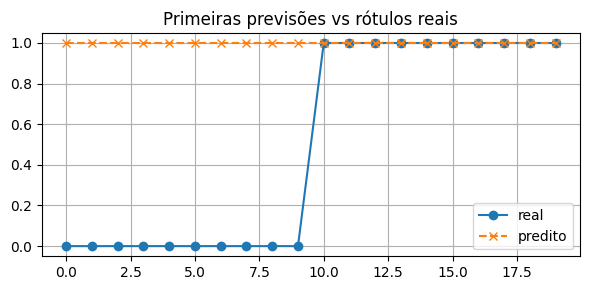

In [21]:
plt.figure(figsize=(6,3))
plt.title('Primeiras previsões vs rótulos reais')
plt.plot(y_true, marker='o', label='real')
plt.plot(y_pred, marker='x', linestyle='--', label='predito')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()